In [1]:
import sys
import glob
import warnings
warnings.filterwarnings('ignore')
from mls import *
from utility import *
import numpy as np
import pandas as pd
import matplotlib as mpl
from cycler import cycler
from facets import facets
from matplotlib import ticker
import matplotlib.pyplot as plt
from scipy.interpolate import griddata,Rbf, InterpolatedUnivariateSpline

In [2]:
floc='/home/pankaj/phd/saturation/plot/October/'
dir='/home/pankaj/phd/saturation/data/raw/mls/'
files=glob.glob(dir+'*')
out='/home/pankaj/phd/saturation/data/mls/'

In [3]:
# Station details
stations=['davs','spol', 'neum', 'myth', 'syow',  'marb','mcmu','mirn']
names=['Davis', 'South Pole', 'Neumayer', 'Maitri', 'Syowa',  'Marambio','McMurdo','Mirny']
clrs=['violet','magenta','orange','olive','red','blue','green','turquoise']
cte_lat=[-69,-90, -71, -70, -69,  -64, -79, 66]
cte_lon=[78, 335,  352,  11,  40,   303, 167, 93]
order=[2,4,1,5,6,3,0,7]
stations,names,clrs,cte_lat,cte_lon=[[stations[i] for i in order],[names[i] for i in order],
 [clrs[i] for i in order],[cte_lat[i] for i in order],[cte_lon[i] for i in order]]
print names

['Neumayer', 'Syowa', 'South Pole', 'Marambio', 'McMurdo', 'Maitri', 'Davis', 'Mirny']


In [4]:
def sat_to_station(mls):
    uniq_day=mls.Date.unique()
    cat=pd.DataFrame([])
    for unique in uniq_day:
        curr=mls[mls.Date==unique].dropna()
        lon,lat,ozo=curr['Lon'],curr['Lat'],curr['Ozo']
        #zi = griddata((lon, lat), ozo, (cte_lon,cte_lat), method='linear')
        rbf = Rbf(lon, lat, ozo, method= 'inverse', epsilon=2)
        zi = rbf(cte_lon,cte_lat)
        zi=pd.DataFrame(data=zi[np.newaxis,:],columns=names)
        cat=pd.concat([cat,zi],axis=0)
    cat=cat.set_index(uniq_day)
    return cat

def sage_pot(sage,pot):
    sage=sage_ozone[['level_0','lat','lon',str(pot)]]
    sage.columns=['Date','Lat','Lon','Ozo']
    sage['Date']=pd.to_datetime(sage.Date)    
    return sage

def mls_pot(mls,pot):
    mls=mls[mls.POT==pot].drop(['POT'],axis=1)
    return mls

In [5]:
mls_ozone=pd.read_csv(out+'mls_09_11.dat',sep='\s+',parse_dates=['Date'])

In [6]:
sage_ozone=pd.read_csv(out+'sage_09_11.dat',sep='\s+')
sage_ozone.reset_index(inplace=True)

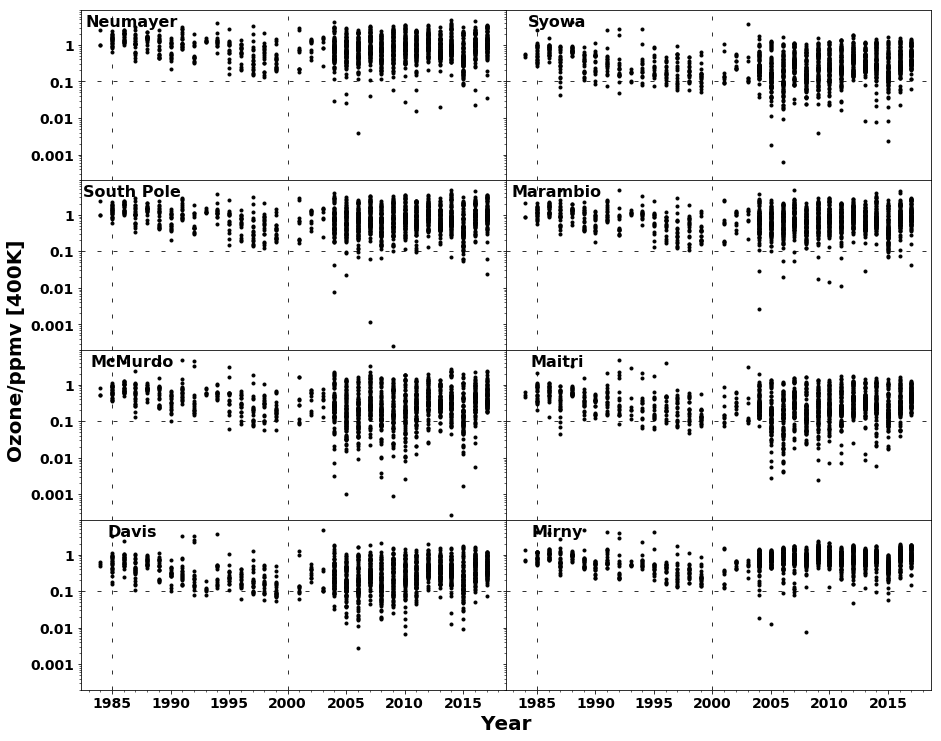

In [7]:
# print cat.columns
pot=400
cat=sat_to_station(pd.concat([sage_pot(sage_ozone,pot),mls_pot(mls_ozone,pot)],axis=0))
cat[cat>=5]=np.nan
cat[cat<=0]=np.nan
fig, axes = facets(4, 2, width=13.0, aspect=0.4, internal_pad=0.0, top_pad=0.1, bottom_pad=0.6, left_pad=1.1, right_pad=0.1)
for col,ax in zip(cat.columns,axes):
    ax.plot(cat.index.year,cat[col],'o',color='black',markersize=3)
    ax.axhline(0.1, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.axvline(1985, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.axvline(2000, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.set_title(col,y=0.869,x=0.12,fontsize=16,fontweight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(logformat))
    ax.set_ylim([0.0002,9])
    ax.minorticks_on()
for ax in axes:
    for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
        l.set_weight("bold")
        l.set_fontsize(14)
axes[-2].set_xlabel('Year',position=(1,0),fontsize=20,fontweight='bold')
axes[4].set_ylabel('Ozone/ppmv [400K]',position=(0,1),fontsize=20,fontweight='bold')
figsave(fig,'sat_400_time_series',floc)
plt.show()

375
400
425
450
475
500
525
550
575


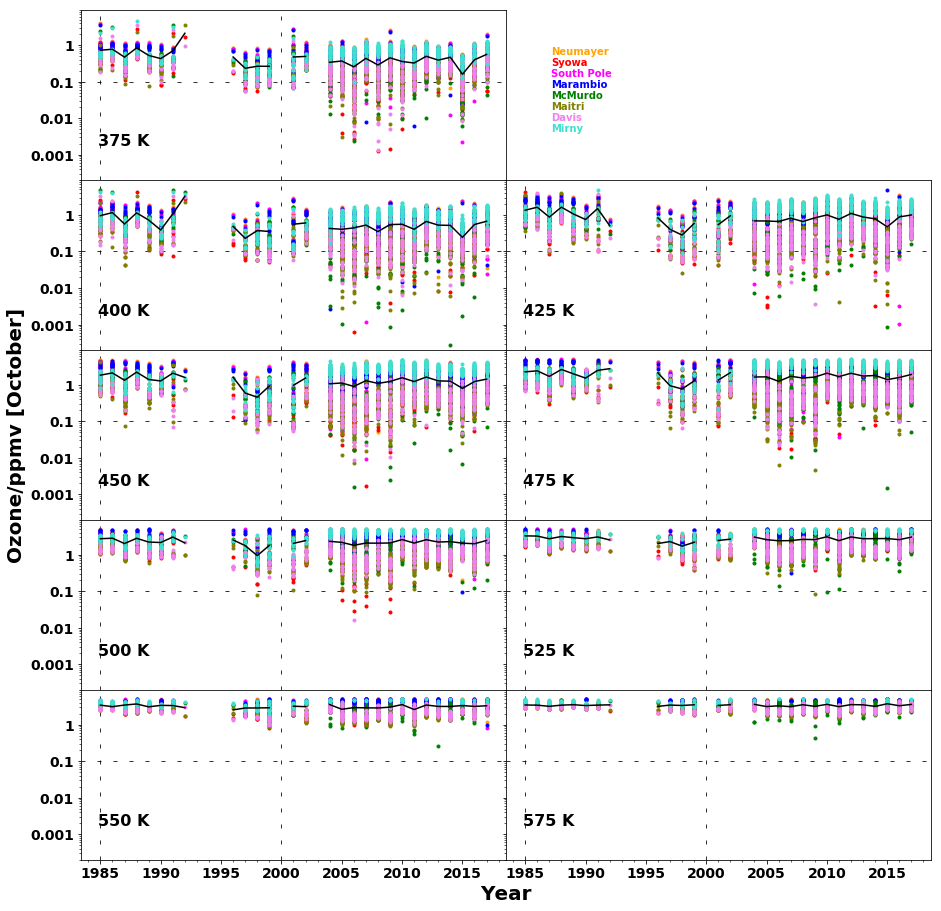

In [8]:
fig, axes = facets(5, 2, width=13.0, aspect=0.4, internal_pad=0.0, top_pad=0.1, bottom_pad=0.6, left_pad=1.1, right_pad=0.1)
axes[1].axis('off')
axs=np.delete(axes,[1])
for pot,ax in zip(np.arange(375,576,25),axs):
    print pot
    cat=sat_to_station(pd.concat([sage_pot(sage_ozone,pot),mls_pot(mls_ozone,pot)],axis=0))
    cat[cat>=5]=np.nan
    cat[cat<=0]=np.nan
    cat=cat[cat.index.month==10]
    ax.set_prop_cycle(cycler('color', clrs))
    ax.plot(cat.index.year,cat,'o',markersize=3)
    dm=cat.groupby(cat.index.year).mean().mean(axis=1)
    yr=np.concatenate((np.arange(1993,1996),np.array([2000,2003])),axis=0)
    for year in yr:
        dm[year]=np.nan
    dm=dm.sort_index()
    ax.plot(dm.index,dm,label=' ', color='black')
    ax.axhline(0.1, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.axvline(1985, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.axvline(2000, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.set_title(str(pot)+' K',y=0.169,x=0.1,fontsize=16,fontweight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(logformat))
    ax.set_ylim([0.0002,9])
    ax.minorticks_on()
for ax in axes:
    for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
        l.set_weight("bold")
        l.set_fontsize(14)
axes[-2].set_xlabel('Year',position=(1,0),fontsize=20,fontweight='bold')
axes[4].set_ylabel('Ozone/ppmv [October]',position=(0,0.5),fontsize=20,fontweight='bold')
leg=axes[0].legend(names, bbox_to_anchor=(1.02, 0.84),markerscale=0,prop=legend_properties,frameon=False,fontsize=18,labelspacing=0.1)
color_legend_texts(leg)
figsave(fig,'sat_375_575_time_series',floc)
plt.show()

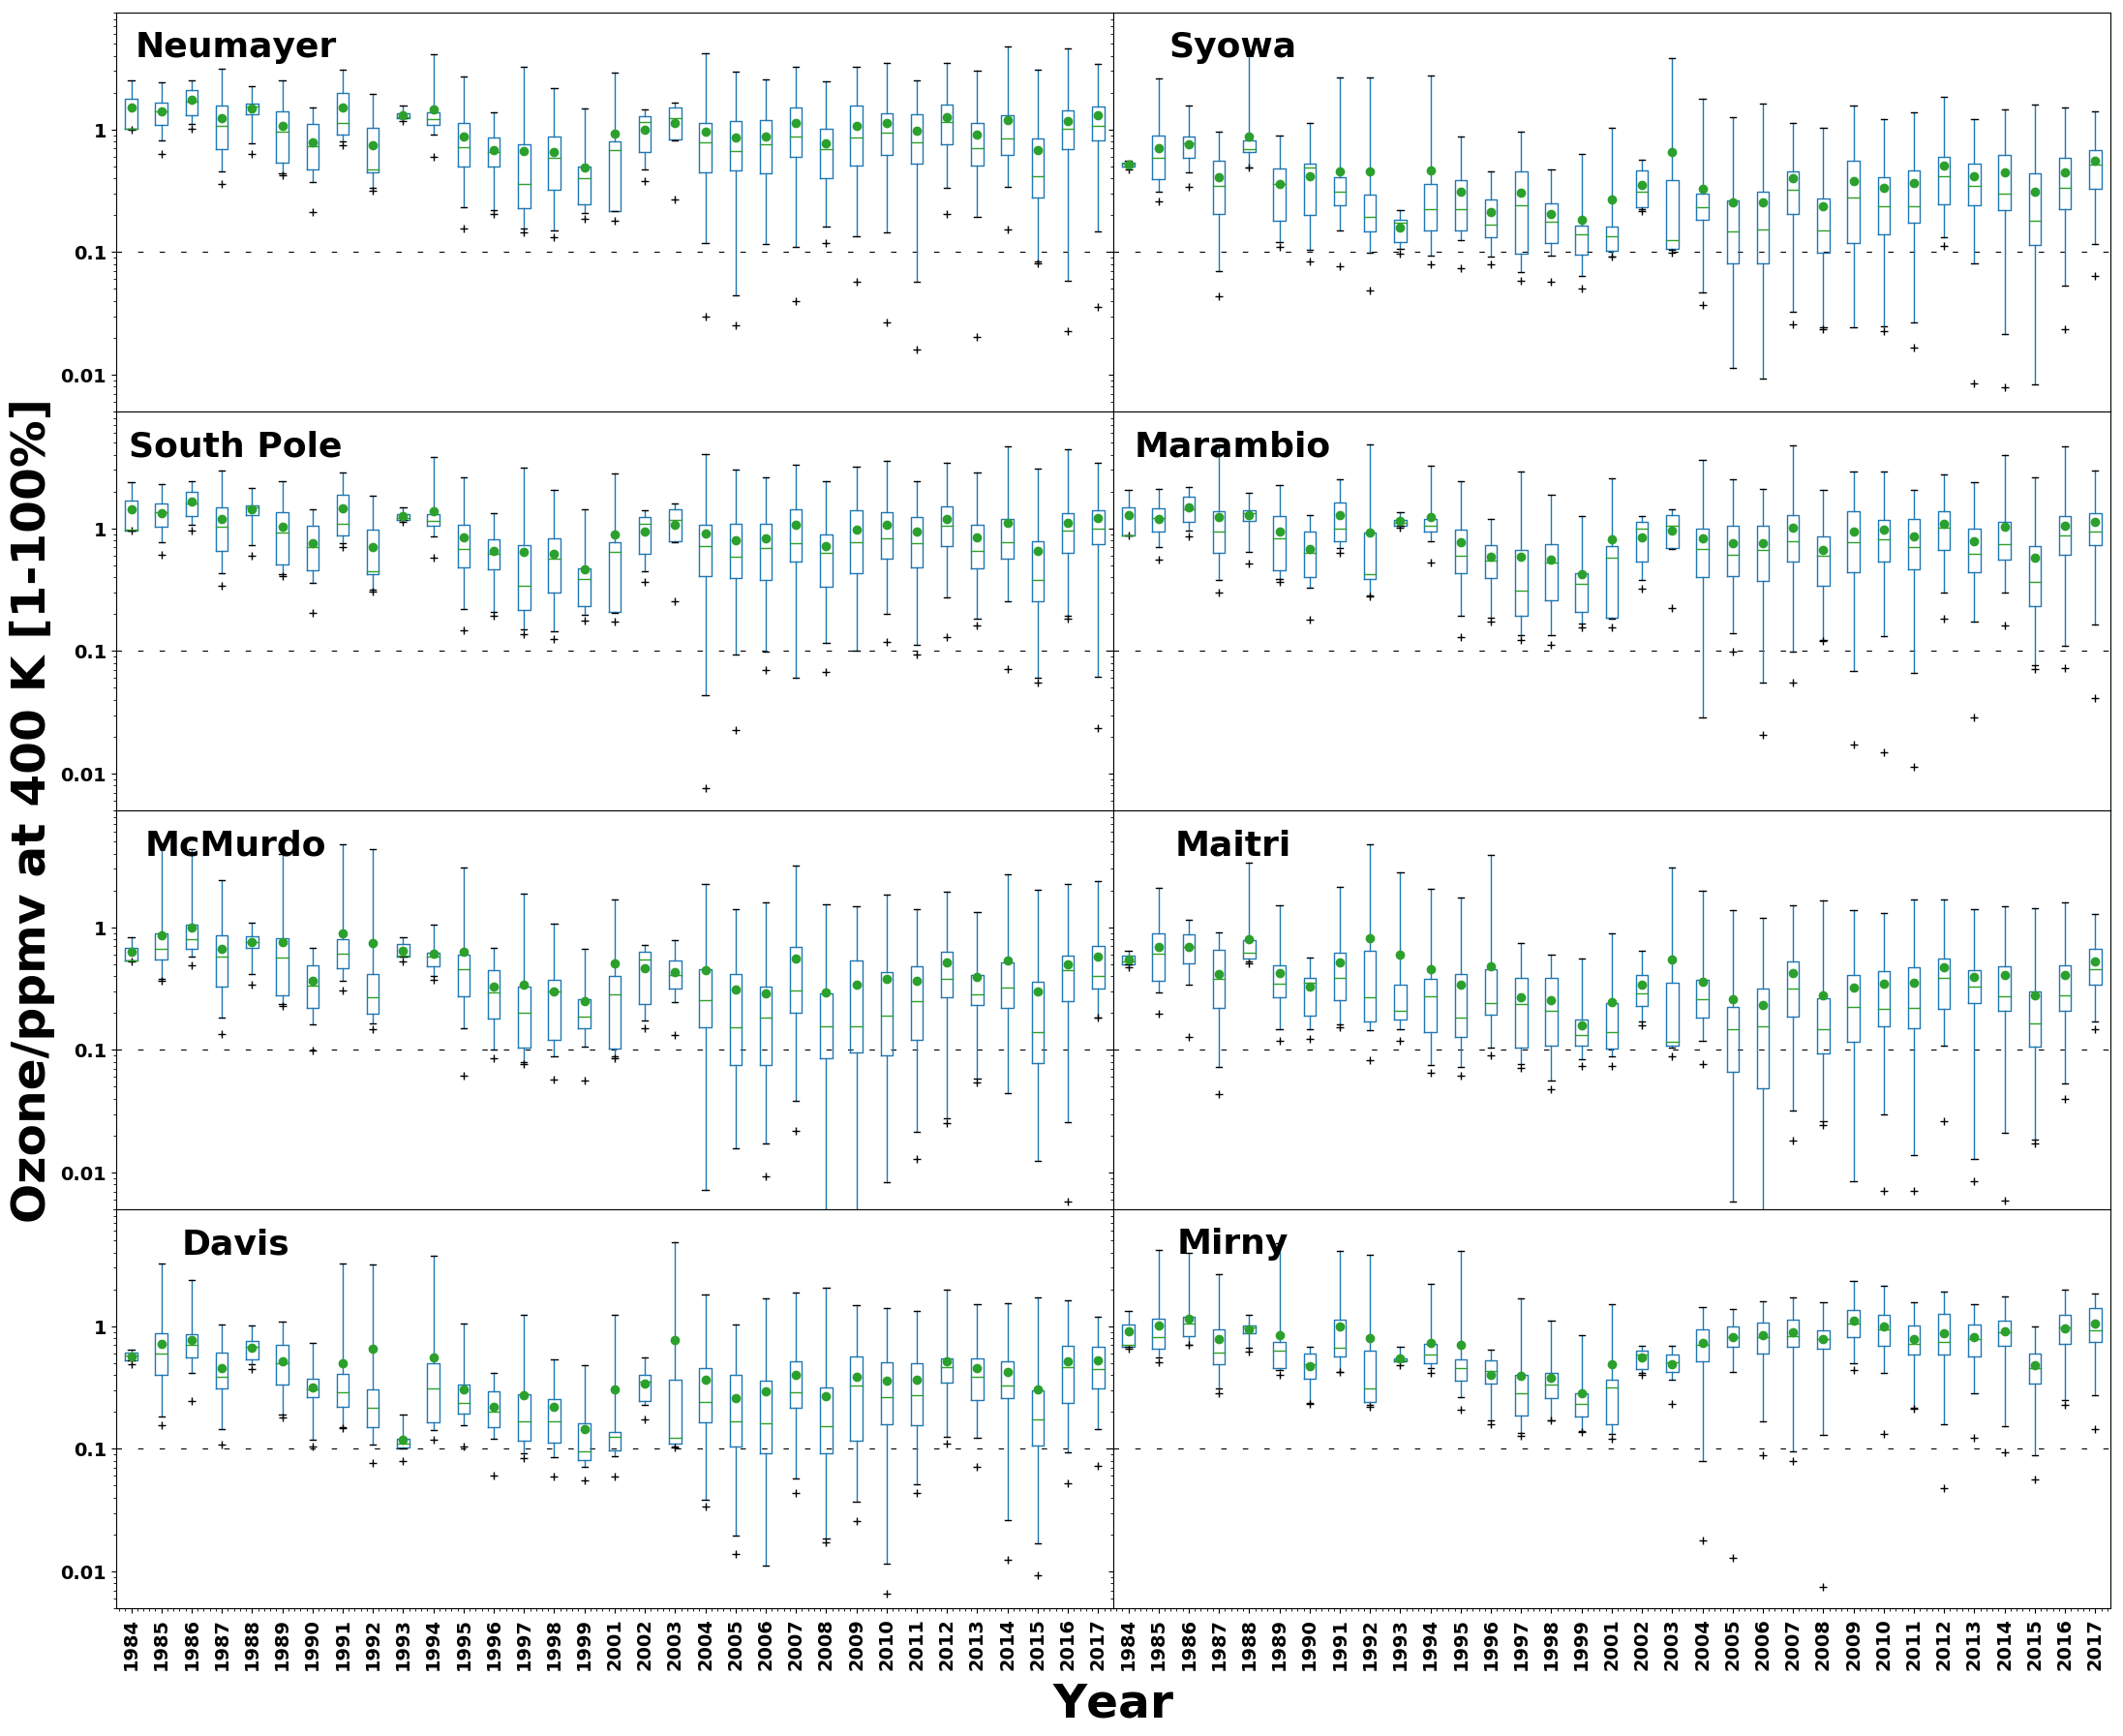

In [9]:
# print cat.columns
mpl.rcParams.update(mpl.rcParamsDefault) 
mpl.rcParams['boxplot.meanprops.marker']='o'
mpl.rcParams['boxplot.meanprops.markersize']=6
pot=400
cat=sat_to_station(pd.concat([sage_pot(sage_ozone,pot),mls_pot(mls_ozone,pot)],axis=0))
cat[cat>=5]=np.nan
cat[cat<=0]=np.nan
fig, axes = facets(4, 2, width=22.0, aspect=0.4, internal_pad=0.0, top_pad=0.1, bottom_pad=1.2, left_pad=1.3, right_pad=0.1)
for col,ax in zip(cat.columns,axes):
    box=pd.DataFrame(columns=['Ozo','Year'])
    box['Ozo']=cat[col]
    box['Year']=cat.index.year
    bp=box.boxplot(column='Ozo',by='Year', ax=ax,return_type='axes',
                sym='k+',whis=[1,100],widths=0.4,manage_xticks=True,showmeans=True)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=90,fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=20,fontweight='bold')
    ax.axhline(0.1, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
#     ax.axvline(1985, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
#     ax.axvline(2000, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.set_title(col,y=0.869,x=0.12,fontsize=26,fontweight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(logformat))
    ax.set_ylim([0.005,9])
    ax.minorticks_on()
    ax.grid(False)
for ax in axes:
    for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
        l.set_weight("bold")
        l.set_fontsize(14)
axes[-2].set_xlabel('Year',position=(1,0),fontsize=35,fontweight='bold',labelpad=8)
axes[4].set_ylabel('Ozone/ppmv at 400 K [1-100%]',position=(0,1),fontsize=35,fontweight='bold')
fig.suptitle('')
axes[-1].set_xlabel('')
figsave(fig,'sat_400_box_plot',floc)
plt.show()

In [10]:
# yrs=np.arange(cat.index.year.min(),cat.index.year.max()+1)
# fig, axes = facets(5, 7, width=18.0, aspect=0.8, internal_pad=0.0, top_pad=0.1, bottom_pad=0.9, left_pad=1.3, right_pad=0.1)
# axes[6].axis('off')
# axs=[]
# for count,axis in enumerate(axes):
#     if count==1:
#         continue
#     axs.append(axis)
# for year,ax in zip(yrs,axs):
#     ax.plot()

375
400
425
450
475
500


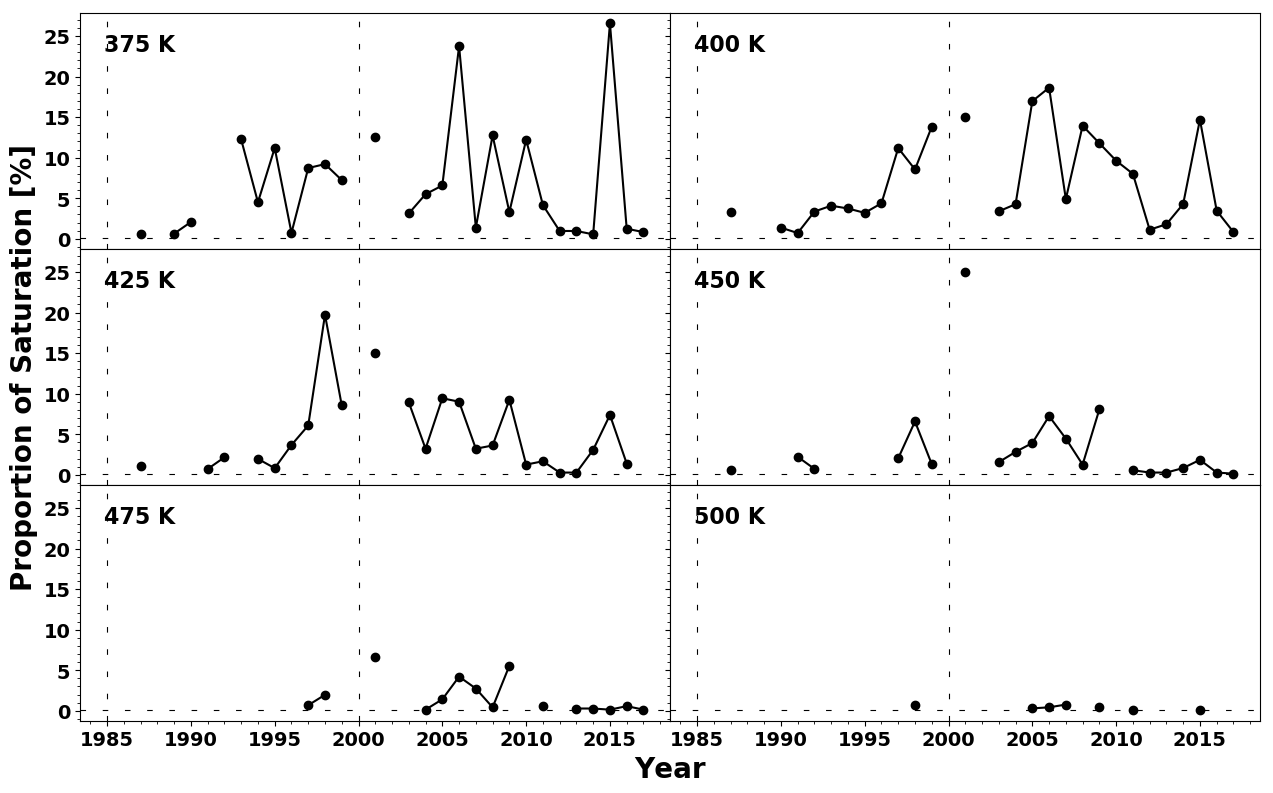

In [11]:
fig, axes = facets(3, 2, width=13.0, aspect=0.4, internal_pad=0.0, top_pad=0.1, bottom_pad=0.6, left_pad=1.1, right_pad=0.1)
for pot,ax in zip(np.arange(375,506,25),axes):
    print pot
    cat=sat_to_station(pd.concat([sage_pot(sage_ozone,pot),mls_pot(mls_ozone,pot)],axis=0))
    cat[cat>=5]=np.nan
    cat[cat<=0]=np.nan
    dm1=cat[cat<=0.1].groupby(cat.index.year).count().sum(axis=1)
    dm2=cat.groupby(cat.index.year).count().sum(axis=1)
    per=pd.DataFrame(index=np.arange(1984,2018))
    per['Ozo']=100*dm1/dm2
    per[per<=0]=np.nan
    ax.plot(per['Ozo'], color='black')
    ax.plot(per['Ozo'],'o',color='black')
    ax.axhline(0.1, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.axvline(1985, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.axvline(2000, color='black', linestyle=(0, (5, 15)), linewidth=0.8,zorder=1)
    ax.set_title(str(pot)+' K',y=0.8,x=0.1,fontsize=16,fontweight='bold')
    #ax.set_ylim([-0.2,38])
    ax.minorticks_on()
for ax in axes:
    for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
        l.set_weight("bold")
        l.set_fontsize(14)
axes[-2].set_xlabel('Year',position=(1,0),fontsize=20,fontweight='bold')
axes[2].set_ylabel('Proportion of Saturation [%]',position=(0,0.5),fontsize=20,fontweight='bold')
figsave(fig,'sat_375_575_proportion_time_series',floc)
plt.show()

375
400
425
450
475
500


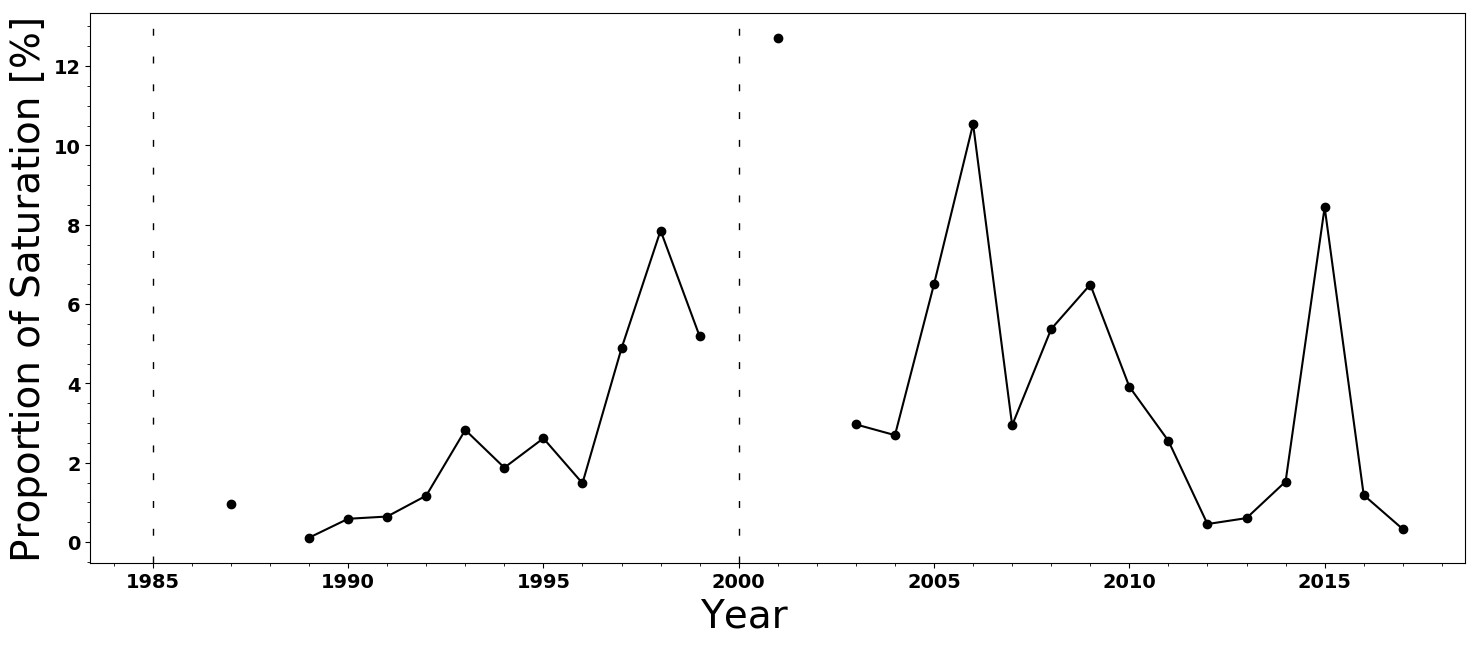

In [12]:
per=pd.DataFrame([])
for pot in np.arange(375,506,25):
    print pot
    cat=sat_to_station(pd.concat([sage_pot(sage_ozone,pot),mls_pot(mls_ozone,pot)],axis=0))
    cat[cat>=5]=np.nan
    cat[cat<=0]=np.nan
    per=pd.concat([per,cat],axis=0)
# print per.head()
fig, axes = facets(1, 1, width=15.0, aspect=0.4, internal_pad=0.0, top_pad=0.5, bottom_pad=0.9, left_pad=1.15, right_pad=0.1)
ax=axes[0]
dm1=per[per<=0.1].groupby(per.index.year).count().sum(axis=1)
dm2=per.groupby(per.index.year).count().sum(axis=1)
per=pd.DataFrame(index=np.arange(1984,2018))
per['Ozo']=100*dm1/dm2
per[per<=0]=np.nan
ax.plot(per['Ozo'], color='black')
ax.plot(per['Ozo'], 'o',color='black')
[ax.axvline(yr, color='black', linestyle=(0, (5, 15)), linewidth=1,zorder=1) for yr in [1985,2000]]
ax.set_xlabel('Year',fontsize=28,position=(0.475,0))
ax.set_ylabel('Proportion of Saturation [%]',fontsize=28)
ax.minorticks_on()
for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
        l.set_weight("bold")
        l.set_fontsize(14)
figsave(fig,'sat_all_proportion_time_series',floc)
plt.show()